In [1]:
import DynamicalSystems as DS
import DynamicalSystems.RecurrenceAnalysis as RA
import Random
import PyPlot as plt
import Statistics

# TODO

1.  Generate noise and choose the most restrictive gamma to determine if a 
system is deterministic;
2.  Make functions to clear the code a bit;
    *   Since I repeat always the same steps, only changing a few variables, it 
    could be easy
3.  Define epsilon_list based in the system;
    *   Some systems can produce numeric values that are quite big;
    *   Maybe I could normalize the system and not worry with this?


## Calculating gamma for a set

### Constants and definitions

In [2]:
sample_size = 50000 # 5% of 1e6
series_size = 1000

epsilon_list = collect(0:0.01:1)
entropy_list = []

deterministic = false
time = [0:1:series_size-1;] # "time", using a sequence from 0 to 999

if deterministic
    #system = DS.Systems.betatransformationmap(0.25, β=2.0)
    #global system = DS.Systems.logistic(0.4, r=4.0) # Selecting system
    #global trajectory = DS.trajectory(system, series_size-1) # evolving trajectory

    global system = DS.Systems.henon([0.0, 0.0]; a=1.4, b=0.3)
    global trajectory = DS.trajectory(system, series_size-1; Ttr=1000)[:, 1]

else
    trajectory = zeros(series_size)
    Random.rand!(trajectory)
end

1000-element Vector{Float64}:
 0.06554621111064407
 0.7566540444600304
 0.8916378663975794
 0.5646606613751782
 0.1720385379039635
 0.3763969883000293
 0.575988266170038
 0.05709896164313577
 0.06642803826081767
 0.9337138804271949
 ⋮
 0.9038054867919565
 0.686417187024587
 0.35050873974399943
 0.2149136443373103
 0.9650402122340889
 0.7665592277854054
 0.442529878278501
 0.5673607302854718
 0.6012148598021775

### Iterating over distinct epsilons in order to maximize entropy

In [3]:
for epsilon in epsilon_list
    print("epsilon is $(epsilon)    \r")
    flush(stdout)
    
    
    # Getting recurrence matrix and transforming it to a simple numeric matrix
    # populated with 1s and 0s
    matrix = RA.RecurrenceMatrix(trajectory, epsilon, parallel=true)
    matrix_fix = ones(size(matrix))
    for i in 1:size(matrix)[1], j in 1:size(matrix)[2]
        matrix_fix[i, j] = matrix[i, j] * 1
    end
    matrix = matrix_fix

    random_index = zeros(sample_size)
    Random.rand!(random_index)
    
    random_index = random_index * series_size^2
    round.(random_index)
    
    x_index = zeros(sample_size)
    y_index = zeros(sample_size)
    
    for (i, index) in enumerate(random_index)
        x_index[i] = index % series_size
        y_index[i] = round(index / series_size)
    end
    
    x_index = trunc.(Int, x_index)
    y_index = trunc.(Int, y_index)
    
    # Verifying border problems
    for (i, j) in enumerate(x_index)
        if j >= series_size
            x_index[i] = series_size - 1
        elseif j == 0
            x_index[i] = 1
        end
    end
    
    for (i, j) in enumerate(y_index)
        if j >= series_size
            y_index[i] = series_size - 1
        elseif j == 0
            y_index[i] = 1
        end
    end
    
    
    
    # Getting matrices from recurrence matrix
    matrices = []
    for (x, y) in zip(x_index, y_index)
        push!(matrices, matrix[x:x+1, y:y+1])
    end
    
    # Counting each type
    possible_matrices = [[0 0; 0 0], [1 0; 0 0], [0 1; 0 0], [0 0; 1 0],
                         [0 0; 0 1], [1 1; 0 0], [1 0; 1 0], [0 0; 1 1],
                         [0 1; 0 1], [1 0; 0 1], [0 1; 1 0], [1 1; 1 0],
                         [0 1; 1 1], [1 0; 1 1], [1 1; 0 1], [1 1; 1 1]]
    
    current_found = zeros(16)
    for (i, current_matrix) in enumerate(possible_matrices)
        for j in matrices
            if current_matrix == j
                current_found[i] += 1
            end
        end
    end
    
    # TODO Divide current_found by sample_size in order to normalize them into
    # probabilities

    current_found = current_found

    current_entropy = 0.0
    for i in current_found
        # expression defined in eq. 4
        current_entropy -= i / sample_size * log(i / sample_size)
    end

    push!(entropy_list, current_entropy)
end

# finding max entropy
max_entropy_epsilon = [0, 0]
for (i, j) in enumerate(entropy_list)
    if j != NaN
        if max_entropy_epsilon[2] < j
            global max_entropy_epsilon = [i, j]
        end
    end
end

max_entropy_epsilon = epsilon_list[convert(Int, max_entropy_epsilon[1])]

print("\nmax entropy is at epsilon = ", max_entropy_epsilon)


max entropy is at epsilon = 0.29

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


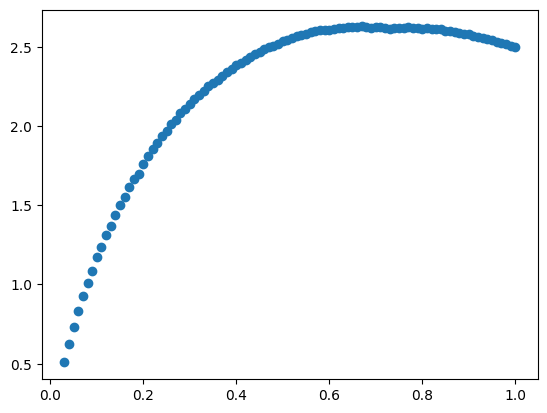

PyObject <matplotlib.collections.LineCollection object at 0x7f6aed69e6d0>

In [ ]:
plt.scatter(epsilon_list, entropy_list)
plt.vlines(max_entropy_epsilon, minimum(entropy_list), maximum(entropy_list))

### With the best known epsilon, calculate the resulting recurrence matrix





a is 4843.0
b is 2120.0
c is 2117.0
d is 2133.0
e is 2112.0
f is 4428.0
g is 4457.0
h is 4207.0
i is 4328.0
j is 3987.0
k is 4031.0
l is 1625.0
m is 1666.0
n is 1621.0
o is 1649.0
p is 4676.0




Total gamma is: 0.02238



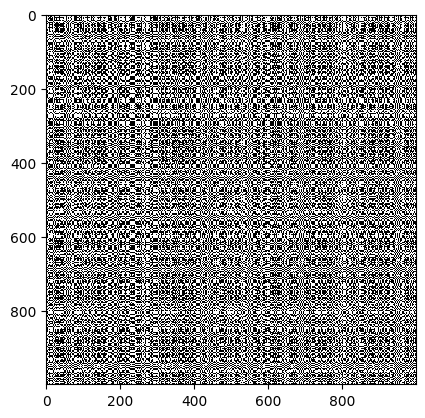

In [ ]:
epsilon = max_entropy_epsilon

# Getting recurrence matrix and transforming it to a simple numeric matrix
# populated with 1s and 0s
matrix = RA.RecurrenceMatrix(trajectory, epsilon, parallel=true)
matrix_fix = ones(size(matrix))
for i in 1:size(matrix)[1], j in 1:size(matrix)[2]
    matrix_fix[i, j] = matrix[i, j] * 1
end
matrix = trunc.(Int, matrix_fix)

plt.scatter(time, trajectory)
plt.savefig("juliaData.png", dpi=600)
plt.close()

plt.imshow(matrix, cmap="Greys", interpolation="none")
plt.savefig("juliaTest.png", dpi=600)


random_index = zeros(sample_size)
Random.rand!(random_index)

random_index = random_index * series_size^2
round.(random_index)

x_index = zeros(sample_size)
y_index = zeros(sample_size)

for (i, index) in enumerate(random_index)
    x_index[i] = index % series_size
    y_index[i] = round(index / series_size)
end

x_index = trunc.(Int, x_index)
y_index = trunc.(Int, y_index)

# Verifying border problems
for (i, j) in enumerate(x_index)
    if j >= series_size
        x_index[i] = series_size - 1
    elseif j == 0
        x_index[i] = 1
    end
end

for (i, j) in enumerate(y_index)
    if j >= series_size
        y_index[i] = series_size - 1
    elseif j == 0
        y_index[i] = 1
    end
end



# Getting matrices from recurrence matrix
matrices = []
for (x, y) in zip(x_index, y_index)
    push!(matrices, matrix[x:x+1, y:y+1])
end

# Counting each type
possible_matrices = [[0 0; 0 0], [1 0; 0 0], [0 1; 0 0], [0 0; 1 0],
                     [0 0; 0 1], [1 1; 0 0], [1 0; 1 0], [0 0; 1 1],
                     [0 1; 0 1], [1 0; 0 1], [0 1; 1 0], [1 1; 1 0],
                     [0 1; 1 1], [1 0; 1 1], [1 1; 0 1], [1 1; 1 1]]

current_found = zeros(16)
for (i, current_matrix) in enumerate(possible_matrices)
    for j in matrices
        if current_matrix == j
            current_found[i] += 1
        end
    end
end

print("\n\n\n")
histogram_values = []
for (i, j) in enumerate("abcdefghijklmnop")
    print("\n", j, " is ", current_found[i])
    push!(histogram_values, current_found[i])
end
print("\n\n\n")

#print("\n\n\n")
#for (i, j) in enumerate("abcdefghijklmnop")
#    print("\n", j, " is ")
#    display(possible_matrices[i])
#end
#print("\n\n\n")

# Calculating gamma by the paper definition
gamma1 = abs(current_found[2] - current_found[3]) +
         abs(current_found[2] - current_found[4]) +
         abs(current_found[2] - current_found[5]) +
         abs(current_found[3] - current_found[4]) +
         abs(current_found[3] - current_found[5]) +
         abs(current_found[4] - current_found[5])


gamma2 = abs(current_found[6] - current_found[7]) +
         abs(current_found[6] - current_found[8]) +
         abs(current_found[6] - current_found[9]) +
         abs(current_found[7] - current_found[8]) +
         abs(current_found[7] - current_found[9]) +
         abs(current_found[8] - current_found[9])

gamma3 = abs(current_found[10] - current_found[11])

gamma4 = abs(current_found[12] - current_found[13]) +
         abs(current_found[12] - current_found[14]) +
         abs(current_found[12] - current_found[15]) +
         abs(current_found[13] - current_found[14]) +
         abs(current_found[13] - current_found[15]) +
         abs(current_found[14] - current_found[15])


total_gamma_system = (gamma1 + gamma2 + gamma3 + gamma4) / sample_size

# multiplying total_gamma by 100, since it should be a percentage
# print("\n\n", "Total gamma is: ", total_gamma * 100, "%\n\n")
print("\n\n", "Total gamma is: ", total_gamma_system, "\n\n")


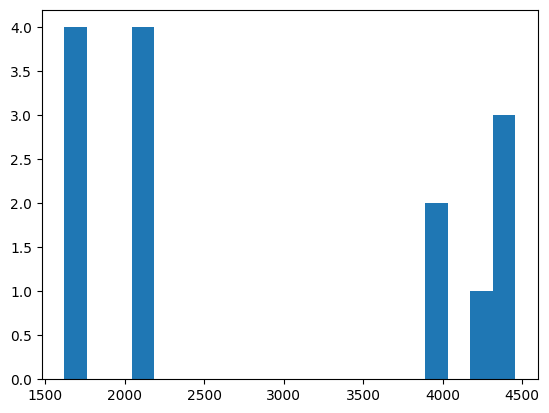

In [ ]:

plt.close()
plt.hist(histogram_values[2:15], 20);

## Calculating 100 gammas for the shuffled dataset

In [ ]:
shuffled_trajectory = Random.shuffle(trajectory)

shuffled_epsilon_list = collect(0:0.01:1)
shuffled_entropy_list = []

Any[]

### Finding best epsilon for the shuffled dataset

In [ ]:

for shuffled_epsilon in shuffled_epsilon_list
    print("epsilon is $(shuffled_epsilon)    \r")
    flush(stdout)
    
    
    # Getting recurrence matrix and transforming it to a simple numeric matrix
    # populated with 1s and 0s
    matrix = RA.RecurrenceMatrix(shuffled_trajectory, shuffled_epsilon, parallel=true)
    matrix_fix = ones(size(matrix))
    for i in 1:size(matrix)[1], j in 1:size(matrix)[2]
        matrix_fix[i, j] = matrix[i, j] * 1
    end
    matrix = matrix_fix

    random_index = zeros(sample_size)
    Random.rand!(random_index)
    
    random_index = random_index * series_size^2
    round.(random_index)
    
    x_index = zeros(sample_size)
    y_index = zeros(sample_size)
    
    for (i, index) in enumerate(random_index)
        x_index[i] = index % series_size
        y_index[i] = round(index / series_size)
    end
    
    x_index = trunc.(Int, x_index)
    y_index = trunc.(Int, y_index)
    
    # Verifying border problems
    for (i, j) in enumerate(x_index)
        if j >= series_size
            x_index[i] = series_size - 1
        elseif j == 0
            x_index[i] = 1
        end
    end
    
    for (i, j) in enumerate(y_index)
        if j >= series_size
            y_index[i] = series_size - 1
        elseif j == 0
            y_index[i] = 1
        end
    end
    
    
    
    # Getting matrices from recurrence matrix
    matrices = []
    for (x, y) in zip(x_index, y_index)
        push!(matrices, matrix[x:x+1, y:y+1])
    end
    
    # Counting each type
    possible_matrices = [[0 0; 0 0], [1 0; 0 0], [0 1; 0 0], [0 0; 1 0],
                         [0 0; 0 1], [1 1; 0 0], [1 0; 1 0], [0 0; 1 1],
                         [0 1; 0 1], [1 0; 0 1], [0 1; 1 0], [1 1; 1 0],
                         [0 1; 1 1], [1 0; 1 1], [1 1; 0 1], [1 1; 1 1]]
    
    current_found = zeros(16)
    for (i, current_matrix) in enumerate(possible_matrices)
        for j in matrices
            if current_matrix == j
                current_found[i] += 1
            end
        end
    end
    
    # TODO Divide current_found by sample_size in order to normalize them into
    # probabilities

    current_found = current_found / sample_size

    current_entropy = 0.0
    for i in current_found
        # expression defined in eq. 4
        current_entropy -= i / sample_size * log(i / sample_size)
    end

    push!(shuffled_entropy_list, current_entropy)
end


In [ ]:

# finding max entropy
max_entropy_epsilon = [0, 0]
for (i, j) in enumerate(shuffled_entropy_list)
    if j != NaN
        if max_entropy_epsilon[2] < j
            max_entropy_epsilon = [i, j]
        end
    end
end

shuffled_max_entropy_epsilon = shuffled_epsilon_list[convert(Int, max_entropy_epsilon[1])]

print("\nmax entropy is at epsilon = ", shuffled_max_entropy_epsilon)


max entropy is at epsilon = 0.65

### With the best known epsilon, calculate the resulting recurrence matrix for 100 gammas

In [ ]:
gammas = []
epsilon = shuffled_max_entropy_epsilon

for current_gamma in 1:100
    print("gamma being calculated is #$(current_gamma)\r")
    flush(stdout)

    # Getting recurrence matrix and transforming it to a simple numeric matrix
    # populated with 1s and 0s
    matrix = RA.RecurrenceMatrix(shuffled_trajectory, epsilon, parallel=true)
    matrix_fix = ones(size(matrix))
    for i in 1:size(matrix)[1], j in 1:size(matrix)[2]
        matrix_fix[i, j] = matrix[i, j] * 1
    end
    matrix = trunc.(Int, matrix_fix)

    random_index = zeros(sample_size)
    Random.rand!(random_index)

    random_index = random_index * series_size^2
    round.(random_index)

    x_index = zeros(sample_size)
    y_index = zeros(sample_size)

    for (i, index) in enumerate(random_index)
        x_index[i] = index % series_size
        y_index[i] = round(index / series_size)
    end

    x_index = trunc.(Int, x_index)
    y_index = trunc.(Int, y_index)

    # Verifying border problems
    for (i, j) in enumerate(x_index)
        if j >= series_size
            x_index[i] = series_size - 1
        elseif j == 0
            x_index[i] = 1
        end
    end

    for (i, j) in enumerate(y_index)
        if j >= series_size
            y_index[i] = series_size - 1
        elseif j == 0
            y_index[i] = 1
        end
    end



    # Getting matrices from recurrence matrix
    matrices = []
    for (x, y) in zip(x_index, y_index)
        push!(matrices, matrix[x:x+1, y:y+1])
    end

    # Counting each type
    possible_matrices = [[0 0; 0 0], [1 0; 0 0], [0 1; 0 0], [0 0; 1 0],
                         [0 0; 0 1], [1 1; 0 0], [1 0; 1 0], [0 0; 1 1],
                         [0 1; 0 1], [1 0; 0 1], [0 1; 1 0], [1 1; 1 0],
                         [0 1; 1 1], [1 0; 1 1], [1 1; 0 1], [1 1; 1 1]]

    current_found = zeros(16)
    for (i, current_matrix) in enumerate(possible_matrices)
        for j in matrices
            if current_matrix == j
                current_found[i] += 1
            end
        end
    end

    # Calculating gamma by the paper definition
    gamma1 = abs(current_found[2] - current_found[3]) +
             abs(current_found[2] - current_found[4]) +
             abs(current_found[2] - current_found[5]) +
             abs(current_found[3] - current_found[4]) +
             abs(current_found[3] - current_found[5]) +
             abs(current_found[4] - current_found[5])


    gamma2 = abs(current_found[6] - current_found[7]) +
             abs(current_found[6] - current_found[8]) +
             abs(current_found[6] - current_found[9]) +
             abs(current_found[7] - current_found[8]) +
             abs(current_found[7] - current_found[9]) +
             abs(current_found[8] - current_found[9])

    gamma3 = abs(current_found[10] - current_found[11])

    gamma4 = abs(current_found[12] - current_found[13]) +
             abs(current_found[12] - current_found[14]) +
             abs(current_found[12] - current_found[15]) +
             abs(current_found[13] - current_found[14]) +
             abs(current_found[13] - current_found[15]) +
             abs(current_found[14] - current_found[15])


    total_gamma = (gamma1 + gamma2 + gamma3 + gamma4) / sample_size

    push!(gammas, total_gamma)
end
# multiplying total_gamma by 100, since it should be a percentage
# print("\n\n", "Total gamma is: ", total_gamma * 100, "%\n\n")
mean = Statistics.mean(gammas)
std_dev = Statistics.std(gammas)
println("Mean gamma is $(mean)")
println("Mean gamma + 3 sigma is $(mean + 3 * std_dev)")


Mean gamma is 0.022747600000000007
Mean gamma + 3 sigma is 0.038085744441525224


## Is the system deterministic?

In [ ]:
if total_gamma_system < (mean + 3 * std_dev)
    println("System is stochastisc.")
elseif total_gamma_system > (mean + 3 * std_dev)
    println("System is deterministic.")
else
    println("Deu ruim")
end

System is deterministic.


## TODO generate noise and choose the most restrictive gamma to determine if a system is deterministic

## Dúvidas

1.  É esse o caminho?
2.  Quais os próximos passos?
    * Já tentar identificar os grupos com uma rede neural?
    * Otimizar métodos?
3.  Como gerar ruído?
    * Protótipo para gaussiano
    * Distribuições mais complexas